In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import*
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    # form data with polynomial degree
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    # ridge regression
    w = ridge_regression(y_tr, tx_tr, lambda_)
    # calculate the loss for train and test data
    loss_tr = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
    loss_te = np.sqrt(2 * compute_mse(y_te, tx_te, w))
    return loss_tr, loss_te,w

#### Question
Pourquoi faut-il faire la moyenne de la loss function à chaque itération?
Pourquoi lors d'une cross validation nous obtenons la RMSE directement?

Est ce que la RMSE représente le coût ou il s'agit de la MSE? Est ce que nous avons le droit de la définir comme tel?

#### Réponse:
Le coût correspond a la MSE et pas à la RMSE

15

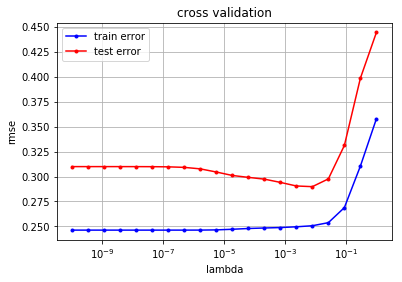

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-10, 0, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    ind_best_lambda =  np.argmin(rmse_te)
    return lambdas[ind_best_lambda],ind_best_lambda
    

best_lambda,ind_best_lambda=cross_validation_demo()
ind_best_lambda


 Searching the best degree

#### Question
Est ce que lorsqu'on fait une cross validation le résultat reste cohérent si l'on test un paramètre indépendament des autres paramètres? Ou faut-il faire une cross validation de tout les paramètres en même temps?

In [8]:
seed = 1
k_fold = 4
degrees = np.arange(2, 11)
lambdas=np.logspace(-10,0,20)
# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
best_lambda=[]
best_rmses=[]

for degree_ in degrees:
    rmse_te=[]
    for lambda_ in lambdas:
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, degree_)
            rmse_te_tmp.append(loss_te)
            
        rmse_te.append(np.mean(rmse_te_tmp))
        
    ind_best_rmse=np.argmin(rmse_te)
    best_rmses.append(rmse_te[ind_best_rmse])
    best_lambda.append(lambdas[ind_best_rmse])
    
ind_best_degree =  np.argmin(best_rmses)
best_degree=degrees[ind_best_degree]
best_degree

7

Compute the variance of the RMSE

#### Question
Pourquoi il n'est pas nécessaire ici de faire la moyenne de la RMSE? Pourquoi la moyenne est vu comme pertinente?

#### Réponse
Car le box plot prend en compte toutes les valeurs du RMSE. Ainsi faire la moyenne ne nous permet pas distinguer les écarts entre les erreurs de chaque test de paramètre.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdca1685f60>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdca16908d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdca1685e10>,
 'medians': [<matplotlib.lines.Line2D at 0x7fdca1690f60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdca16982e8>,
 'means': []}

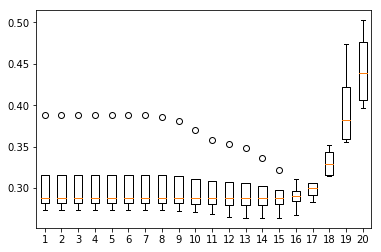

In [9]:
seed = 1
k_fold = 4
lambdas=np.logspace(-10,0,20)
# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_te=[]
rmse_tr=[]
variance=[]
rmse_te_moy=[]

for lambda_ in lambdas:
    rmse_tr_tmp=[]
    rmse_te_tmp = []
    
    for k in range(k_fold):
        loss_tr, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, best_degree)
        rmse_te_tmp.append(loss_te)
        rmse_tr_tmp.append(loss_tr)
            
    rmse_te.append(rmse_te_tmp)
    rmse_te_moy.append(np.mean(rmse_te_tmp))
    rmse_tr.append(rmse_tr_tmp)
    variance.append(loss_te)
ind_lambda=np.argmin(rmse_te_moy)
plt.boxplot(rmse_te)


## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

#### Question
Que représente les traits fins? Même question pour les traits épais du grahique

#### Réponse
Traits fins: tout les RMSEs en fonction du degrée

Traits épais: la moyenne de tout les RMSEs en fonction du degrée

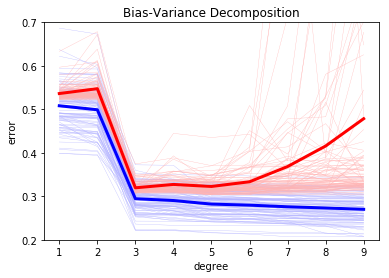

In [10]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo_LS():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        
        for index_degree, degree in enumerate(degrees):
            # form polynomial data
            tx_tr = build_poly(x_tr, degree)  #!!! CHANGER DE VARIABLE QUAND ON FAIT BUID_POLY !!!!!
            tx_te = build_poly(x_te, degree)
            # least square
            w = least_squares(y_tr, tx_tr)
            # calculate the rmse for train and test
            rmse_tr[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
            rmse_te[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_te, tx_te, w))
           

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo_LS()

La variance augmente avec le degree du polynome. Comme nous le montre le graphique suivant, dans les grands degrées les courbes des RMSEs sont chaotiques et très importante. Cela nous montre donc une augmentation de la variance pour les valeurs de test.

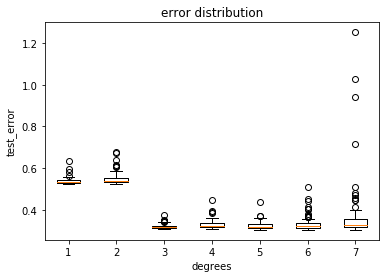

In [25]:
def bias_variance_demo_LS_BP():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    
    ratio_train = 0.005
    degrees = range(1, 8)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        
        for index_degree, degree in enumerate(degrees):
            # form polynomial data
            tx_tr = build_poly(x_tr, degree)  #!!! CHANGER DE VARIABLE QUAND ON FAIT BUID_POLY !!!!!
            tx_te = build_poly(x_te, degree)
            # least square
            w = least_squares(y_tr, tx_tr)
            # calculate the rmse for train and test
            rmse_tr[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
            rmse_te[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_te, tx_te, w))
           
    plt.boxplot(rmse_te)
    plt.title("error distribution")
    plt.xlabel("degrees")
    plt.ylabel("test_error")
    
bias_variance_demo_LS_BP()

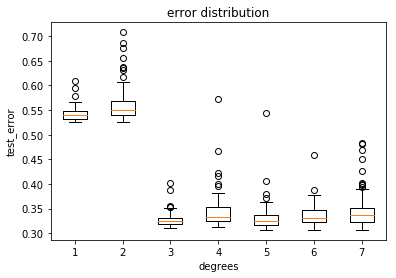

In [26]:
from ridge_regression import ridge_regression
def bias_variance_demo_RR():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    
    ratio_train = 0.005
    lambdas = np.logspace(-10,0,30)
    degrees = range(1, 8)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        k_fold = 4
        k_indices = build_k_indices(y_tr, k_fold, 1)
        
        for index_degree, degree in enumerate(degrees):
            # form polynomial data
            tx_tr = build_poly(x_tr, degree)
            tx_te = build_poly(x_te, degree)
            
            # ridge regression
            # define lists to store the loss of training data and test data
            rmse_te_tmp1 = []
            ws=[]
            for lambda_ in lambdas:
                rmse_te_tmp2 = []
                ws_tmp=[]
                for k in range(k_fold):
                    _, loss_te,w = cross_validation(y_tr, x_tr, k_indices, k, lambda_, degree)
                    rmse_te_tmp2.append(loss_te)
                    ws_tmp.append(w)
                rmse_te_tmp1.append(np.mean(rmse_te_tmp2))
                ws.append(ws_tmp)
             
            ind_ws_opt=np.argmin(rmse_te_tmp1)
            w_opt=ws[ind_ws_opt]
            lambda_opt=lambdas[ind_ws_opt]
            
            # calculate the rmse for train and test
            rmse_te[index_seed, index_degree] = np.mean([np.sqrt(2 * compute_mse(y_te, tx_te, w)) for w in w_opt])
            
    plt.boxplot(rmse_te)
    plt.title("error distribution")
    plt.xlabel("degrees")
    plt.ylabel("test_error")

bias_variance_demo_RR()

Suite à une ridge regression, les données sont plus étalées de facon continues comme le montre le boxplot ci-dessus. Ceci est dû à l'ajout d'une pénalité lambda. Il va réduire l'impact des données aberrantes et ainsi réduire leurs erreurs(leurs variances).

#### Question:
Est ce que la ridge regression diminue uniquement les erreurs des valeurs externes? Comment fait elle varié le biais?